In [12]:
import os
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette("tab10")

## Data Generator

1. Download the CWRU dataset [here.](https://engineering.case.edu/bearingdatacenter/download-data-file)
1. Download the JNU dataset [here.](http://mad-net.org:8765/explore.html?t=0.5831516555847212)

# Load data

In [13]:
dataset = np.load('CWRU_Quantum_5.npz')

In [14]:

X = dataset['data']
y = dataset['label']

print(X)

[[1.24209681e-02 5.61899448e-03 7.59820698e-02 4.16396308e-01
  2.17794462e-01]
 [1.15889513e-02 4.82543586e-03 7.04254191e-02 4.85030769e-01
  2.12161846e-01]
 [1.46434147e-02 5.92844959e-03 7.83765219e-02 4.20568615e-01
  2.12370462e-01]
 ...
 [4.27066385e-03 2.86213699e-01 5.35006484e-01 6.43608593e+00
  3.13621627e+00]
 [4.59228223e-03 2.91095217e-01 5.39551950e-01 8.88195289e+00
  4.94736796e+00]
 [5.00035291e-03 3.88521474e-01 6.23334964e-01 1.07430534e+01
  5.85538034e+00]]


In [15]:
print(X.shape)

(1305, 5)


## Hybrid Quantum Classical Machine Learning

In [19]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq  
import sympy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit #to print the circuit

### Classical Data Preprocessing

In [26]:
# Code a function to perform preprocessing on the classical dataset
def prepare_classic_dataset():
    
    #CWRU = 10 ; JNU = 12
    n_modes = 10

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =1)
    
    scaler = MinMaxScaler(feature_range = [0, np.pi])                                                  
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)                                                                  
     
    y_train = np.eye(n_modes)[y_train]                                                                      
    y_test = np.eye(n_modes)[y_test]

    
    return x_train, x_test, y_train, y_test


In [27]:
# Prepare the classical dataset by calling the previous function

x_train, x_test, y_train, y_test = prepare_classic_dataset()


### Quantum Data Preprocessing: Encoding Schemas
* Encoding schema: __Angle Encoding__
    

In [28]:
# Code a function to perform Angle Encoding of the preprocssed classical data

def prepare_quantum_dataset(x):
  
    q = cirq.GridQubit.rect(1, len(x)) 
    
    ops = [cirq.ry(2 * x[i]).on(q[i]) for i in range(len(x))]

    circuit = cirq.Circuit(ops)
    
    return circuit
    

[1.61956594 1.46152269 2.05895785 1.13290918 1.21137884]


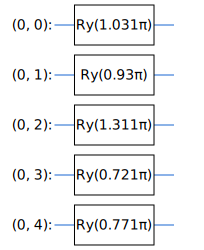

In [32]:
# Do the actual quantum dataset preparation from the preprocessed classical data

x_train_q = [prepare_quantum_dataset(x) for x in x_train]
x_test_q = [prepare_quantum_dataset(x) for x in x_test]

print(x_train[0])
SVGCircuit(x_train_q[0])


### Parameterized Quantum Circuit (PQC)

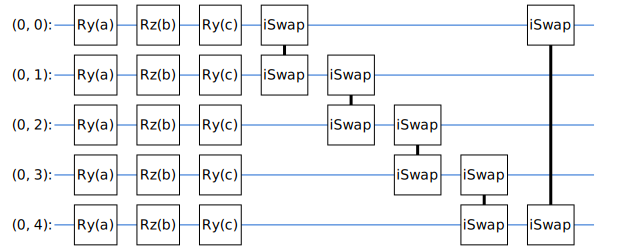

In [33]:
# Implement the PQC

n_layers = 1
qubits = X.shape[1]

params = sympy.symbols('a b c')  

q = cirq.GridQubit.rect(1, qubits)

ops = [] 

'''
# Only parameterized rotations architecture
for j in range(n_layers):
  for i in range(qubits):
    ops.append(cirq.ry(params[0]).on(q[i])) 
    ops.append(cirq.rx(params[1]).on(q[i]))
    ops.append(cirq.rz(params[2]).on(q[i]))
    #ops.append(cirq.H(params[3]).on(q[i]))

'''

# Entanglement configuration


for j in range(n_layers):
  for i in range(qubits):
      #Euler rotation
      ops.append(cirq.ry(params[0]).on(q[i])) 
      ops.append(cirq.rz(params[1]).on(q[i]))
      ops.append(cirq.ry(params[2]).on(q[i]))


  ops.append(cirq.ISWAP(q[0], q[1]))
  ops.append(cirq.ISWAP(q[1], q[2]))
  ops.append(cirq.ISWAP(q[2], q[3]))
  ops.append(cirq.ISWAP(q[3], q[4]))
  ops.append(cirq.ISWAP(q[4], q[0]))



# two-qubit gate architectures used in the paper:
'''
  #Cnot two-qubit gate
  ops.append(cirq.CNOT(control=q[0], target=q[1]))
  ops.append(cirq.CNOT(control=q[1], target=q[2]))
  ops.append(cirq.CNOT(control=q[2], target=q[3]))
  ops.append(cirq.CNOT(control=q[3], target=q[4]))
  ops.append(cirq.CNOT(control=q[4], target=q[0]))

'''

'''
  #CZ two-qubit gate
  ops.append(cirq.CZ(q[0], q[1]))
  ops.append(cirq.CZ(q[1], q[2]))
  ops.append(cirq.CZ(q[2], q[3]))
  ops.append(cirq.CZ(q[3], q[4]))
  ops.append(cirq.CZ(q[4], q[0]))
'''

'''
    #iSwap two-qubit gate
  ops.append(cirq.ISWAP(q[0], q[1]))
  ops.append(cirq.ISWAP(q[1], q[2]))
  ops.append(cirq.ISWAP(q[2], q[3]))
  ops.append(cirq.ISWAP(q[3], q[4]))
  ops.append(cirq.ISWAP(q[4], q[0]))

'''
model_circuit = cirq.Circuit(ops)

SVGCircuit(model_circuit) 

### Measurement, Classical Neural Net and Hybrid Model

### Training the Hybrid Quantum - Classical Model

In [34]:
# define our early stopping

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience = 30)

In [35]:
# Training

from tensorflow.keras import optimizers

import time

start = time.time()

nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), 
tf.keras.layers.Dense(10,activation = 'softmax')]) #sigmoid // softmax

circuit_input = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuits_input')


measurement_ops = [cirq.Z(q[i]) for i in range(qubits)] 

circuit_layer = tfq.layers.PQC(model_circuit, measurement_ops)


model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)))


optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])#,'Precision','recall', 'f1score'])

history = model.fit(x = tfq.convert_to_tensor(x_train_q), y = y_train, epochs = 300, verbose = 1, validation_split = 0.1, callbacks=[es])

loss, acc = model.evaluate(tfq.convert_to_tensor(x_test_q), y_test, verbose = 2)


end = time.time()
print("Run time:", end - start)


Train on 939 samples, validate on 105 samples
Epoch 1/300
939/939 [==============================] - 1s 2ms/sample - loss: 1.5476 - accuracy: 0.4590 - val_loss: 1.0619 - val_accuracy: 0.5810
Epoch 2/300
939/939 [==============================] - 0s 357us/sample - loss: 0.9128 - accuracy: 0.6858 - val_loss: 0.7888 - val_accuracy: 0.7333
Epoch 3/300
939/939 [==============================] - 0s 373us/sample - loss: 0.6782 - accuracy: 0.7923 - val_loss: 0.6985 - val_accuracy: 0.7048
Epoch 4/300
939/939 [==============================] - 0s 359us/sample - loss: 0.5034 - accuracy: 0.8392 - val_loss: 0.5712 - val_accuracy: 0.7524
Epoch 5/300
939/939 [==============================] - 0s 353us/sample - loss: 0.4185 - accuracy: 0.8605 - val_loss: 0.4862 - val_accuracy: 0.8190
Epoch 6/300
939/939 [==============================] - 0s 366us/sample - loss: 0.3494 - accuracy: 0.8924 - val_loss: 0.4395 - val_accuracy: 0.8667
Epoch 7/300
939/939 [==============================] - 0s 361us/sample - l

KeyboardInterrupt: 

### Testing the Hybrid Quantum - Classical Model

In [118]:
# Evaluate the model on the test dataset

y_test_ne = np.argmax(y_test, axis = 1)
y_test_pred_ne = np.argmax(model.predict(tfq.convert_to_tensor(x_test_q)), axis = 1)

cm = confusion_matrix(y_test_ne, y_test_pred_ne)

print(cm)

261/261 - 0s - loss: 0.0726 - accuracy: 0.9655
[[53  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0 20  1  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  2  0]
 [ 0  0  0  0  0  0 21  0  1  0]
 [ 0  0  0  0  0  0  0 34  0  2]
 [ 0  0  1  0  0  0  1  0 24  0]
 [ 0  0  0  0  0  0  0  0  0 18]]


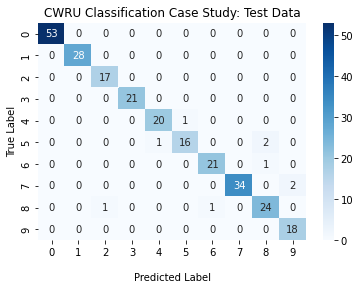

In [119]:

# Plot the confusion matrix

import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('CWRU Classification Case Study: Test Data');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');


## Display the visualization of the Confusion Matrix.
plt.show()




In [ ]:
# Classification report (test set)

from sklearn.metrics import classification_report

class_report_best = classification_report(y_pred = y_test_pred_ne , y_true = y_test_ne, digits = 4)
print(class_report_best)
runtime = end - start
print(runtime)

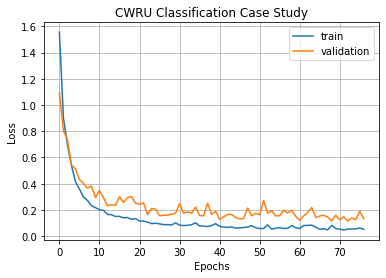

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("CWRU Classification Case Study")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

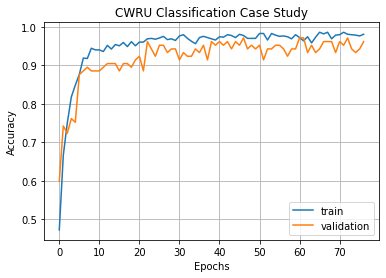

In [123]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("CWRU Classification Case Study")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()
#plt.show()
plt.savefig(r"C:\Users\User\Documents\Lavinia\images\CWRU\CWRU_5feat\iswap1_accuracy.jpg")